In [937]:
import rasterio
import tqdm
import leafmap
import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import concurrent.futures
from mpire import WorkerPool
from skimage.restoration import denoise_tv_bregman
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.var import VAR
from pathlib import Path
import backoff
from urllib3.exceptions import HTTPError
import requests
from rasterio.io import MemoryFile
import io
import asf_search as asf
from shapely.geometry import shape
from rasterio.crs import CRS

In [938]:
BURST_ID = 'T009_019294_IW2'

In [939]:
# get only the RTC products for a burst id
resp = asf.search(operaBurstID=[BURST_ID], processingLevel='RTC')
assert resp

In [940]:
properties = [r.properties for r in resp]
geometry = [shape(r.geojson()['geometry']) for r in resp]
properties_f = [{'opera_id': p['sceneName'], 
                 'start_time': pd.to_datetime(p['startTime']),
                 'polarization': p['polarization'],
                 'url_vh': p['url'], 
                 'url_vv': (p['url'].replace('_VH.tif', '_VV.tif')),
                 'track_number': p['pathNumber']} for p in properties]

df_rtc_ts = gpd.GeoDataFrame(properties_f, geometry=geometry, crs=CRS.from_epsg(4326))
df_rtc_ts = df_rtc_ts.sort_values(by='start_time')
df_rtc_ts.drop(columns=['polarization'], inplace=True)
print(df_rtc_ts.shape)
df_rtc_ts.head()

(20, 6)


,opera_id,start_time,url_vh,url_vv,track_number,geometry
19,OPERA_L2_RTC-S1_T009-019294-IW2_20231007T08475...,2023-10-07 08:47:51+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,9,"POLYGON ((143.32562 -5.40839, 143.36870 -5.398..."
18,OPERA_L2_RTC-S1_T009-019294-IW2_20231019T08475...,2023-10-19 08:47:51+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,9,"POLYGON ((143.32543 -5.40847, 143.36851 -5.398..."
17,OPERA_L2_RTC-S1_T009-019294-IW2_20231031T08475...,2023-10-31 08:47:51+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,9,"POLYGON ((143.32647 -5.40917, 144.11392 -5.234..."
16,OPERA_L2_RTC-S1_T009-019294-IW2_20231112T08475...,2023-11-12 08:47:51+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,9,"POLYGON ((143.32594 -5.40897, 144.11342 -5.234..."
15,OPERA_L2_RTC-S1_T009-019294-IW2_20231124T08475...,2023-11-24 08:47:50+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,9,"POLYGON ((143.32749 -5.40822, 144.11495 -5.233..."


In [941]:
df_rtc_ts.shape

(20, 6)

There can be duplicates.

In [942]:
df_rtc_ts['dedup_id'] = df_rtc_ts.opera_id.map(lambda id_: '_'.join(id_.split('_')[:5]))
df_rtc_ts.head()

,opera_id,start_time,url_vh,url_vv,track_number,geometry,dedup_id
19,OPERA_L2_RTC-S1_T009-019294-IW2_20231007T08475...,2023-10-07 08:47:51+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,9,"POLYGON ((143.32562 -5.40839, 143.36870 -5.398...",OPERA_L2_RTC-S1_T009-019294-IW2_20231007T084751Z
18,OPERA_L2_RTC-S1_T009-019294-IW2_20231019T08475...,2023-10-19 08:47:51+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,9,"POLYGON ((143.32543 -5.40847, 143.36851 -5.398...",OPERA_L2_RTC-S1_T009-019294-IW2_20231019T084751Z
17,OPERA_L2_RTC-S1_T009-019294-IW2_20231031T08475...,2023-10-31 08:47:51+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,9,"POLYGON ((143.32647 -5.40917, 144.11392 -5.234...",OPERA_L2_RTC-S1_T009-019294-IW2_20231031T084751Z
16,OPERA_L2_RTC-S1_T009-019294-IW2_20231112T08475...,2023-11-12 08:47:51+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,9,"POLYGON ((143.32594 -5.40897, 144.11342 -5.234...",OPERA_L2_RTC-S1_T009-019294-IW2_20231112T084751Z
15,OPERA_L2_RTC-S1_T009-019294-IW2_20231124T08475...,2023-11-24 08:47:50+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,9,"POLYGON ((143.32749 -5.40822, 144.11495 -5.233...",OPERA_L2_RTC-S1_T009-019294-IW2_20231124T084750Z


Duplicate RTCs

In [943]:
df_rtc_ts = df_rtc_ts.drop_duplicates(subset=['dedup_id'])
df_rtc_ts.shape

(20, 7)

Need ~/.netrc with earthdata credentials for below to work!

In [944]:
@backoff.on_exception(backoff.expo,
                      HTTPError,
                      max_tries=10,
                      max_time=60,
                      jitter=backoff.full_jitter)
def read_bytes(url: str,) -> bytes:
    resp = requests.get(url)
    data = io.BytesIO(resp.content)
    return data


def read_one_asf(url: str) -> tuple[np.ndarray, dict]:
    img_bytes = read_bytes(url)
    with MemoryFile(img_bytes, filename=url.split('/')[-1]) as memfile:
        with memfile.open() as dataset:
            arr = dataset.read(1).astype(np.float32)
            prof = dataset.profile
    del img_bytes
    return arr, prof


@backoff.on_exception(backoff.expo,
                      HTTPError,
                      max_tries=10,
                      max_time=60,
                      jitter=backoff.full_jitter)
def open_one(path: str) -> tuple:
    with rasterio.open(path) as ds:
        X = ds.read(1)
        p = ds.profile
    X = np.clip(X, 0, 1)
    return (X), p

def normalize_pol_ratio(img: np.ndarray, max_factor: float = 4.):
    vmax = max_factor
    vmin = 1e-7
    
    img_out = img.copy()
    img_out = np.clip(img_out, vmin, vmax)

    img_out = (img_out - vmin) / (vmax - vmin)    
    return img_out
    

def despeckle_one(X: np.ndarray, reg_param=2, noise_floor_db = -22) -> np.ndarray:
    X_c = np.clip(X, 1e-7, 1)
    X_db = 10 * np.log10(X_c, out=np.full(X_c.shape, np.nan), where=(~np.isnan(X_c)))
    X_db[np.isnan(X_c)] = noise_floor_db
    X_db_dspkl = denoise_tv_bregman(X_db, weight=.2, isotropic=True, eps=1e-3)
    X_dspkl = np.power(10, X_db_dspkl / 10.)
    X_dspkl[np.isnan(X)] = np.nan
    X_dspkl = np.clip(X_dspkl, 0, 1)
    return X_dspkl

In [945]:
I = 0
K = df_rtc_ts.shape[0]

with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    data = list(tqdm(executor.map(read_one_asf, df_rtc_ts.url_vv[I:I + K]), total=K))
arrs_vv, profiles = zip(*data)

100%|████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.58s/it]


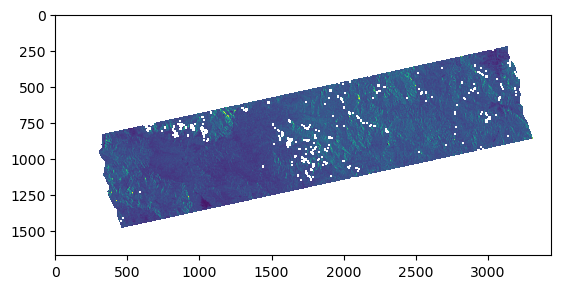

In [946]:
plt.imshow(arrs_vv[0], vmin=0, vmax=1)

In [11]:
I = 0
K = df_rtc_ts.shape[0]

with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    data = list(tqdm(executor.map(read_one_asf, df_rtc_ts.url_vh[I:I + K]), total=K))
arrs_vh, profiles = zip(*data)

100%|████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.46s/it]


In [493]:
with WorkerPool(n_jobs=10, use_dill=True) as pool:
    arrs_vv_d = pool.map(despeckle_one,
                         arrs_vv, 
                         progress_bar=True, 
                         progress_bar_style='notebook', 
                         concatenate_numpy_output=False)

  0%|                                                                             | 0/20 [00:00<?, ?it/s]

In [494]:
with WorkerPool(n_jobs=10, use_dill=True) as pool:
    arrs_vh_d = pool.map(despeckle_one, 
                         arrs_vh, 
                         progress_bar=True, 
                         progress_bar_style='notebook', 
                         concatenate_numpy_output=False)

  0%|                                                                             | 0/20 [00:00<?, ?it/s]

In [1227]:
from astropy.convolution import convolve

def get_spatiotemporal_mu_1d(arrs: np.ndarray,
                             kernel_width=3,
                             kernel_height=3) -> np.ndarray:
    k_shape = (1, kernel_height, kernel_width)
    kernel = np.ones(k_shape, dtype=np.float32) / np.prod(k_shape)
    
    mus_spatial = convolve(arrs, 
                           kernel, 
                           boundary="extend", 
                           nan_treatment='interpolate')
    mu_st = np.mean(mus_spatial, axis=0)
    return mu_st

def get_spatiotemporal_var_1d(arrs: np.ndarray,
                              mu_st=None,
                              kernel_width=3,
                              kernel_height=3
                              ) -> np.ndarray:
    if mu_st is None:
        mu_st = get_spatiotemporal_mu(arrs, 
                                      kernel_width=kernel_width, 
                                      kernel_height=kernel_height)
    
    k_shape = (1, kernel_height, kernel_width)
    kernel = np.ones(k_shape, dtype=np.float32) / np.prod(k_shape)
    
    var_s = convolve((arrs - mu_st)**2, 
                     kernel, 
                     boundary="extend", 
                     nan_treatment='interpolate')
    var_st = np.mean(var_s, axis=0) 
    return var_st

def get_spatiotemporal_cor(arrs: np.ndarray,
                                mu_st=None,
                                kernel_width=3,
                                kernel_height=3
                              ) -> np.ndarray:
    _, C, _, _ = arrs.shape
    if C != 2:
        raise ValueError('input arrs must have 2 channels!')
    if mu_st is None:
        mu_st = get_spatiotemporal_mu(arrs, 
                                      kernel_width=kernel_width, 
                                      kernel_height=kernel_height)
    CC, _, _ = mu_st.shape
    if CC != 2:
        raise ValueError('spatiotemporal mean must be 2!')
    
    k_shape = (1, kernel_height, kernel_width)
    kernel = np.ones(k_shape, dtype=np.float32) / np.prod(k_shape)

    covar_s = convolve((arrs[:, 0, ...] - mu_st[0, ...]) * (arrs[:, 1, ...] - mu_st[1, ...]), 
                       kernel, 
                       boundary="extend", 
                       nan_treatment='interpolate')
    covar_st = np.mean(covar_s, axis=0) 
    return covar_st


def get_spatiotemporal_mu(arrs: np.ndarray,
                             kernel_width=3,
                             kernel_height=3) -> np.ndarray:
    T, C, H, W = arrs.shape
    mu_st = np.full((C, H, W), np.nan)
    for c in range(C):
        mu_st[c,...] = get_spatiotemporal_mu_1d(arrs[:, c, ...])
    
    return mu_st

def get_spatiotemporal_covar(arrs: np.ndarray,
                              mu_st=None,
                              kernel_width=3,
                              kernel_height=3
                              ) -> np.ndarray:
    if mu_st is None:
        mu_st = get_spatiotemporal_mu(arrs, 
                                      kernel_width=kernel_width, 
                                      kernel_height=kernel_height)
    
    T, C, H, W = arrs.shape
    cov_st = np.full((C, C, H, W), np.nan)
    for c in range(C):
        cov_st[c, c,...] = get_spatiotemporal_var_1d(arrs[:, c, ...], 
                                                     mu_st=mu_st[c, ...], 
                                                     kernel_width=kernel_width, 
                                                     kernel_height=kernel_height)
    for c in range(C):
        for d in range(c, C):
            if c != d:

                covar_temp = get_spatiotemporal_cor(arrs[:, [c, d], ...], 
                                                    mu_st=mu_st[[c, d], ...], 
                                                    kernel_width=kernel_width, 
                                                    kernel_height=kernel_height)
                cov_st[c, d,...] = covar_temp
                cov_st[d, c,...] = covar_temp
    return cov_st

def invert_2d_cov(cov: np.ndarray) -> np.ndarray:
    det = cov[0, 0, ...] * cov[1, 1, ...] - 2 * cov[0, 1, ...]
    covar_inv = np.full(cov.shape, np.nan)
    covar_inv[0, 0, ...] = 1 / det * cov[1, 1, ...]
    covar_inv[1, 1, ...] = 1 / det * cov[0, 0, ...]
    t = - 1 / det * cov[0, 1, ...]
    covar_inv[0, 1, ...] = t
    covar_inv[1, 0, ...] = t
    return covar_inv

def get_eigh_2by2(cov_mat: np.ndarray) -> np.ndarray:
    """
    References:
    https://math.stackexchange.com/questions/395698/fast-way-to-calculate-eigen-of-2x2-matrix-using-a-formula
    https://people.math.harvard.edu/~knill/teaching/math21b2004/exhibits/2dmatrices/index.html
    """
    det = cov_mat[0, 0, ...] * cov_mat[1, 1, ...] -  cov_mat[0, 1, ...] * cov_mat[1, 0, ...]
    tr = cov_mat[0, 0, ...] + cov_mat[1, 1, ...] 
    print(tr.shape)
    print(det.shape)
    
    eigval = np.zeros((2, cov_mat.shape[2], cov_mat.shape[3]), dtype=np.float32)
    eigval[0, ...] = .5 * (tr + np.sqrt(tr**2 + 4 * det))
    eigval[1, ...] = .5 * (tr - np.sqrt(tr**2 + 4 * det))

    
    eigvec = np.zeros(cov_mat.shape)

    case_1 = (np.abs(cov_mat[0, 1, ...]) <= 1e-7)
    case_2 = ~case_1

    case_1_cov = cov_mat[..., case_1]
    case_1_eigval = eigval[:, case_1]
    
    case_2_cov = cov_mat[..., ~case_1]
    case_2_eigval = eigval[:, ~case_1]
    
    eigvec[0, 0, case_1] = case_1_eigval[0, ...] - case_1_cov[1, 1, ...]
    eigvec[1, 0, case_1] = case_1_cov[0, 1, ...]
    
    # Make sure the eigenvector is normalized so that the matrix of eigenvectors has an inverse that is its transpose
    n = np.sqrt(eigvec[1, 0, case_1] ** 2 + eigvec[0, 0, case_1]**2)
    eigvec[0, 0, case_1] /= n
    eigvec[1, 0, case_1] /= n

    eigvec[0, 1, case_1] = case_1_eigval[1, ...] - case_1_cov[1, 1, ...]
    eigvec[1, 1, case_1] = case_1_cov[1, 0, ...]

    # Make sure the eigenvector is normalized so that the matrix of eigenvectors has an inverse that is its transpose
    n = np.sqrt(eigvec[0, 1, case_1] ** 2 + eigvec[1, 1, case_1]**2)
    eigvec[0, 1, case_1] /= n
    eigvec[1, 1, case_1] /= n

    eigvec[0, 0, case_2] = 1
    eigvec[1, 1, case_2] = 1
    
    return eigval, eigvec


def get_mahalanobis_dist(pre_arrs: np.ndarray,
                         post_arr: np.ndarray,
                         kernel_width=3,
                         kernel_height=3,
                         eig_lb: float = .0001 * np.sqrt(2), #(1e-4 * 2 ** .5), #6.309e-3,#(.01 * 2 ** .5)
                        ) -> tuple[np.ndarray]:
                
    mu_st = get_spatiotemporal_mu(pre_arrs, 
                                  kernel_width=kernel_width, 
                                  kernel_height=kernel_height)
    covar_st = get_spatiotemporal_covar(pre_arrs, 
                                        mu_st=mu_st, 
                                        kernel_width=kernel_width, 
                                        kernel_height=kernel_height)

    eigval, eigvec = get_eigh_2by2(covar_st)
    # This is the floor we discused earlier except this is for the variance matrix so our LB is .01
    # We want the matrix norm to be at least .01 so we make sure each eigenvalue is .01 * \sqrt 2
    eigval_clip = np.maximum(eigval,  eig_lb)
    eigval_clip_inv = eigval_clip ** -1
    
    # Diag matrix is the diagonal matrix of eigenvalues
    diag_matrix = np.zeros(eigvec.shape, dtype=np.float32)
    diag_matrix[0, 0, ...] = eigval_clip_inv[0, ...] 
    diag_matrix[1, 1, ...] = eigval_clip_inv[1, ...]

    # Matrix multiplication to reconstruct the Sigma^-1  = V^T D V where V is the 
    # matrix whose colums are eignevectors and D is the diagonal matrix of eigenvalues
    covar_st_inv_floor_t = np.einsum('ijmn,jkmn->ikmn', diag_matrix, eigvec)
    covar_st_inv_floor = np.einsum('ijmn,jkmn->ikmn', eigvec.transpose([1, 0, 2, 3]), covar_st_inv_floor_t)
    
    # Finally compute the Mahalanobis distance!
    vec = post_arr - mu_st
    dist_0 = np.einsum('ijkl,jkl->ikl', covar_st_inv_floor, vec)
    dist_1 = np.einsum('ijk,ijk->jk', vec, dist_0)
    dist = np.sqrt(dist_1)
    return mu_st, covar_st, covar_st_inv_floor, dist, eigval

In [1245]:
c[..., 1000, 1000]

array([[1.87083779e-04, 1.51600128e-05],
       [1.51600128e-05, 1.13122901e-05]])

In [1243]:
(c[0, 1, ...] != c[1, 0,...]).sum()

3757785

In [1248]:
(np.isnan(c)).sum() / 4

3757785.0

In [1229]:
# dual_pol = [np.stack([vv, vh], axis=0) for (vv, vh) in zip(arrs_vv_d, arrs_vh_d)]
# ts = np.stack(dual_pol, axis=0)
# ts.shape

In [1230]:
# for (k, dt) in enumerate(df_rtc_ts.start_time):
#     print(k, dt)

In [1231]:
c[..., 1000, 1000]

array([[1.87083779e-04, 1.51600128e-05],
       [1.51600128e-05, 1.13122901e-05]])

In [1232]:
P = 10 # start of pre-images
Q = 9 # Post Image index (choose index of earliest date after event, then subtract P)
pre = ts[P: P + Q, ...]
post = ts[P + Q, ...]
post.shape

(2, 1669, 3440)

In [1233]:
m, c, cinv_c, d, eigvals = get_mahalanobis_dist((pre), (post))

(1669, 3440)
(1669, 3440)


Visualizing with threshoding pre and post image (VV).

In [1250]:
eigvals[0, 1000, 1000]

0.00020748825

In [1251]:
np.diagonal(c[..., 1000, 1000])

array([1.87083779e-04, 1.13122901e-05])

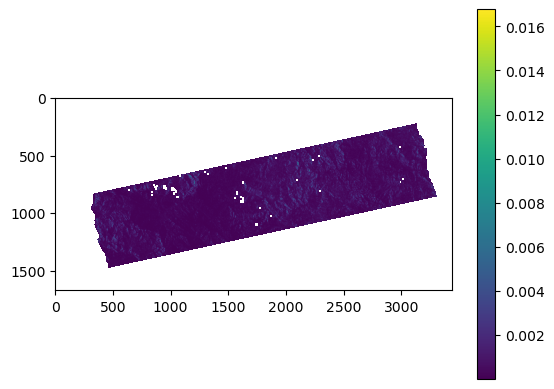

In [1252]:
tr = c[0, 0, ...] + c[1, 1, ...] 
plt.imshow(tr)
plt.colorbar()

In [1253]:
det = c[0, 0, ...] * c[1, 1, ...] - 2 * c[0, 1, ...]

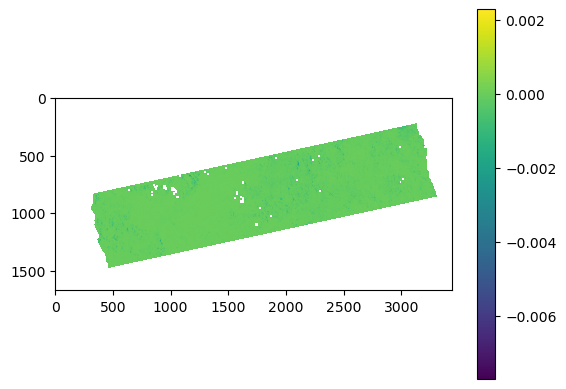

In [1254]:
plt.imshow(det)
plt.colorbar()

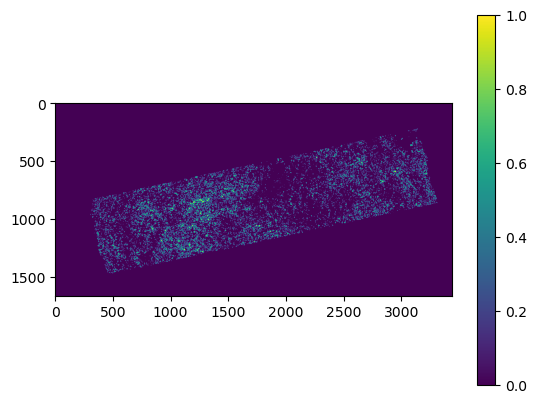

In [1255]:
dsc = tr**2 - 4 * det
plt.imshow(dsc < 0)
plt.colorbar()

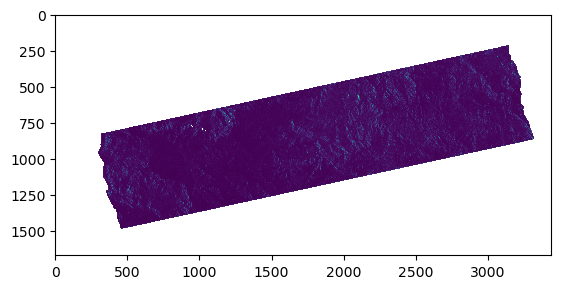

In [1256]:
plt.imshow(eigvals[0, ...], interpolation='none')

In [1257]:
(~np.isnan(d)).sum() * .003

5939.634

In [1258]:
f'{d[~np.isnan(d)].size:,d}'

'1,979,878'

In [1259]:
( d > 3).sum()

46906

(array([1.729404e+06, 2.382690e+05, 1.145400e+04, 6.210000e+02,
        6.800000e+01, 3.100000e+01, 1.100000e+01, 1.000000e+01,
        4.000000e+00, 6.000000e+00]),
 array([1.92892590e-04, 1.91488133e+00, 3.82956977e+00, 5.74425822e+00,
        7.65894666e+00, 9.57363510e+00, 1.14883235e+01, 1.34030120e+01,
        1.53177004e+01, 1.72323889e+01, 1.91470773e+01]),
 <BarContainer object of 10 artists>)

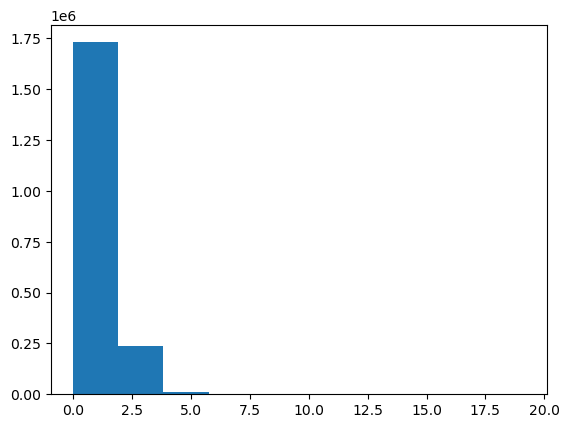

In [1260]:
plt.hist(d.ravel())

In [1261]:
np.nanpercentile(d, 99.7)

4.295910857722407

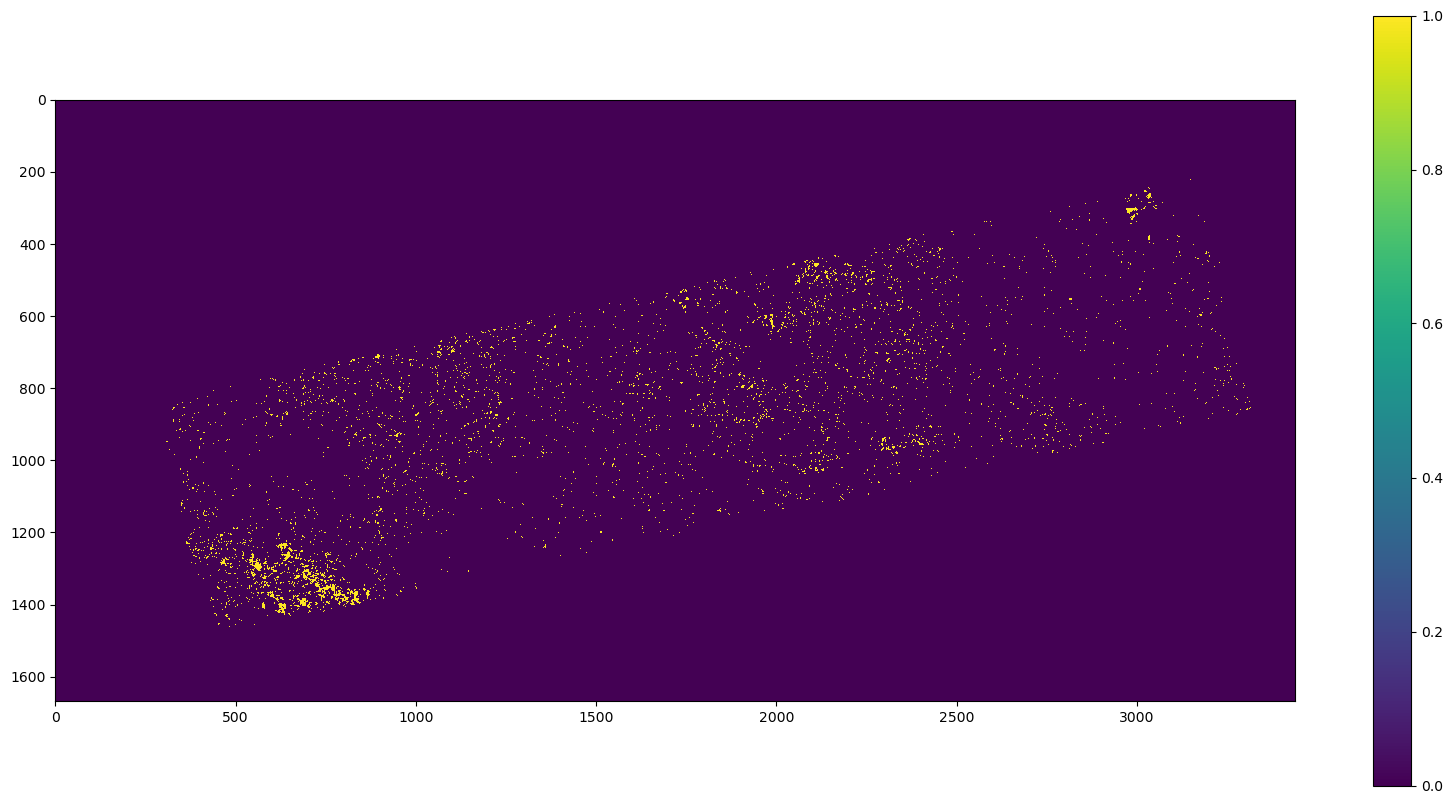

In [1262]:
plt.figure(figsize=(20, 10))
plt.imshow(d > 3, interpolation='none', vmin=0, vmax=1)
plt.colorbar()

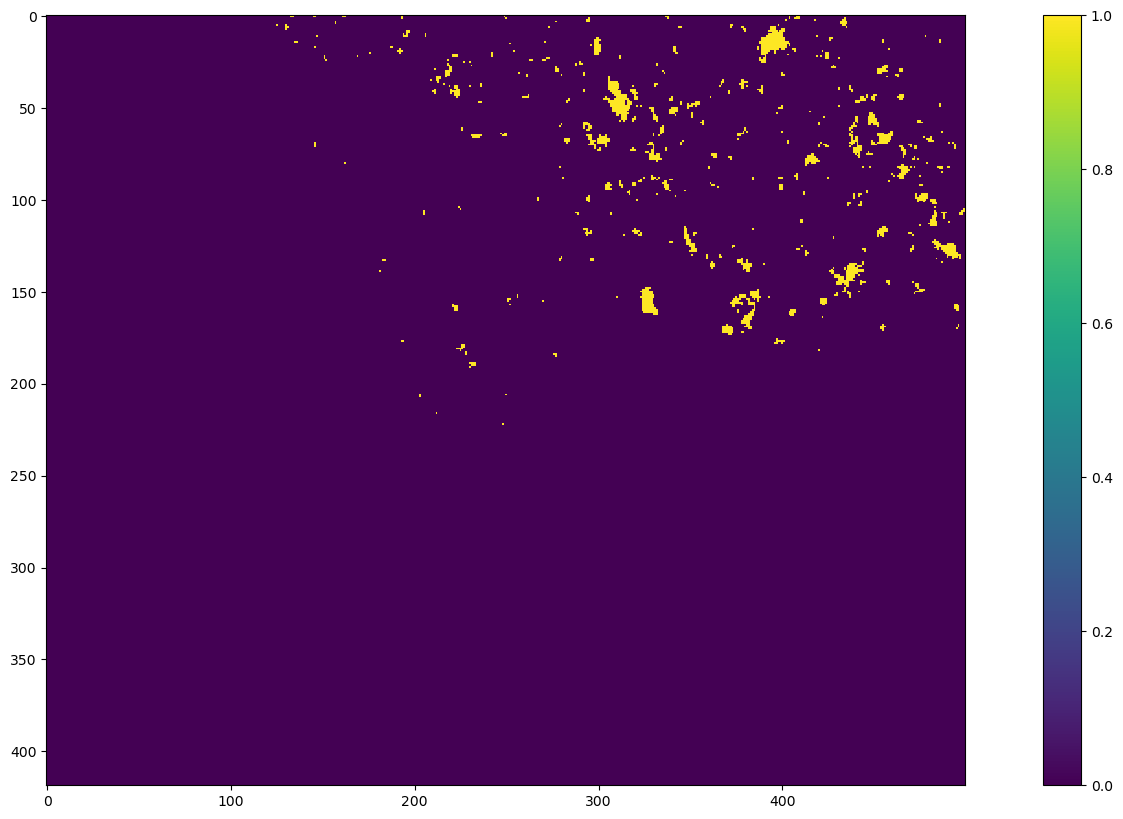

In [1263]:
plt.figure(figsize=(20, 10))
plt.imshow(d[1250:, 250:750] > 4, interpolation='none', vmin=0, vmax=1)
plt.colorbar()

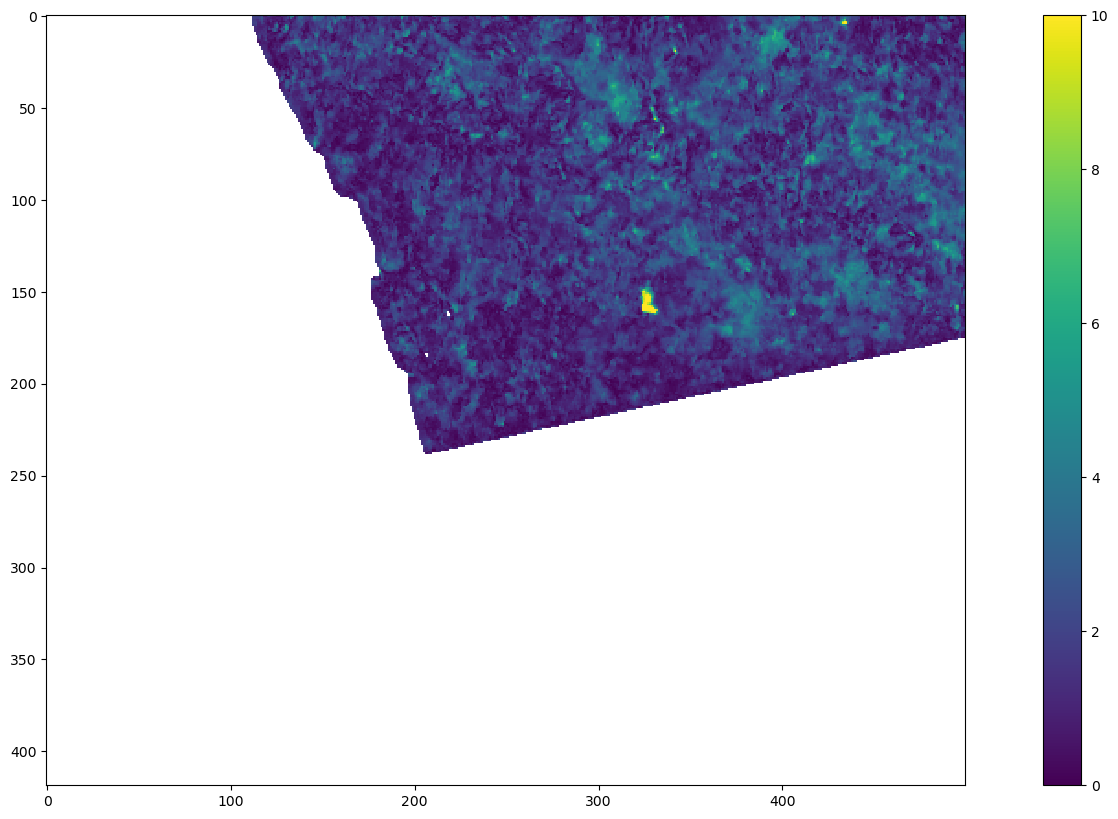

In [1264]:
plt.figure(figsize=(20, 10))
plt.imshow(d[1250:, 250:750] , interpolation='none', vmin=0, vmax=10)
plt.colorbar()

# Serialize data

In [1265]:
dst_dir = Path('out') / BURST_ID 
date = str(df_rtc_ts.start_time.dt.date[P + Q])
dst_dir.mkdir(exist_ok=True, parents=True)

In [1266]:
p = profiles[0]

dst_path = dst_dir / f'dist_{date}__P{P}_Q{Q}.tif'
with rasterio.open(dst_path, 'w', **p) as ds:
    ds.write(d, 1)

In [1267]:
p_int = profiles[0].copy()
p_int['dtype'] = 'uint8'
p_int['nodata'] = 255

dst_path = dst_dir / f'change_{date}__P{P}_Q{Q}.tif'
with rasterio.open(dst_path, 'w', **p_int) as ds:
    X = (d > 3).astype('uint8')
    X[np.isnan(arrs_vh[P+Q])] = 255
    ds.write(X, 1)

(416,)


(array([ 1.,  0.,  0.,  1.,  2.,  4.,  2.,  5.,  1.,  4.,  6.,  3.,  3.,
         6.,  6.,  7.,  2., 12.,  5.,  9., 10.,  7., 16., 11.,  8., 11.,
        10., 10., 13., 15., 18., 19., 14., 19., 15., 16., 13.,  8., 12.,
        12., 18., 12., 12.,  9.,  7.,  8.,  8.,  1.,  2.,  3.]),
 array([0.01629723, 0.01725371, 0.0182102 , 0.01916669, 0.02012317,
        0.02107966, 0.02203615, 0.02299263, 0.02394912, 0.0249056 ,
        0.02586209, 0.02681858, 0.02777506, 0.02873155, 0.02968804,
        0.03064452, 0.03160101, 0.03255749, 0.03351398, 0.03447047,
        0.03542695, 0.03638344, 0.03733993, 0.03829641, 0.0392529 ,
        0.04020938, 0.04116587, 0.04212236, 0.04307884, 0.04403533,
        0.04499182, 0.0459483 , 0.04690479, 0.04786127, 0.04881776,
        0.04977425, 0.05073073, 0.05168722, 0.05264371, 0.05360019,
        0.05455668, 0.05551316, 0.05646965, 0.05742614, 0.05838262,
        0.05933911, 0.0602956 , 0.06125208, 0.06220857, 0.06316505,
        0.06412154]),
 <BarContainer

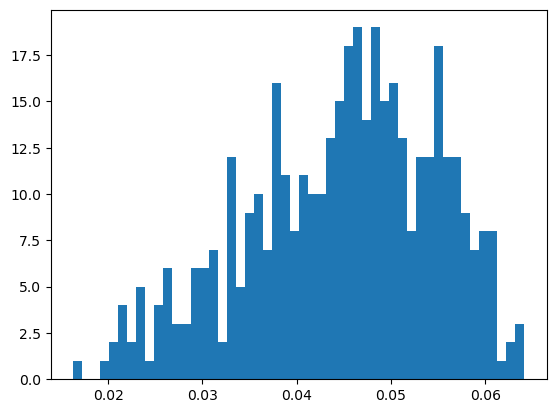

In [1268]:
X = pre[:, -1, 1250:1265, 350:365]
data_log = 10* np.log10(X[~np.isnan(X)])
data = (X[~np.isnan(X)])
print(data.shape)
plt.hist((data), bins=50)

In [1269]:
import scipy.stats as stats
vh_params = stats.norm.fit(data)
vh_params_g = stats.gamma.fit(data)

In [1270]:
XMIN = 0
XMAX = 0.1

In [1271]:
x = np.linspace(XMIN, XMAX, 100)
vh_pdf = stats.norm.pdf(x, *vh_params)
vh_pdf_g = stats.gamma.pdf(x, *vh_params_g)

vh_pdf_g.shape

(100,)

In [1272]:
vh_params

(0.04469727504474208, 0.010064697847312242)

(0.0, 0.1)

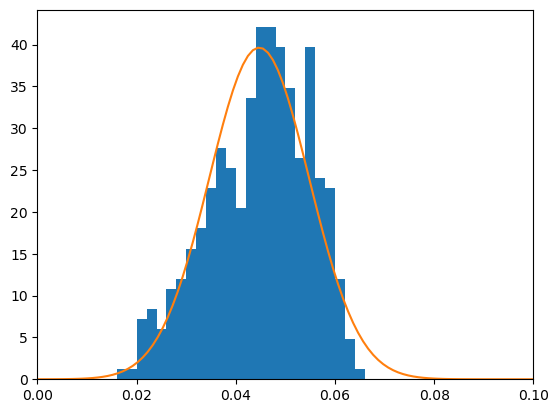

In [1273]:
plt.hist((data), bins=50, density=True, range=(XMIN, XMAX))
sim_data = stats.norm.rvs(size=100, *vh_params)
#sim_data_g = stats.gamma.rvs(size=100, *vh_params_g)

plt.plot(x, vh_pdf)
#plt.hist(sim_data, bins=50, density=True, range=(XMIN, XMAX), alpha=.5)
plt.xlim(XMIN, XMAX)

(array([ 0.,  0.,  0.,  0.,  0., 14., 10., 26., 50., 48., 28., 16.,  4.,
         0.,  2.,  2.,  0.,  0.,  0.,  0.]),
 array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
        0.09 , 0.095, 0.1  ]),
 <BarContainer object of 20 artists>)

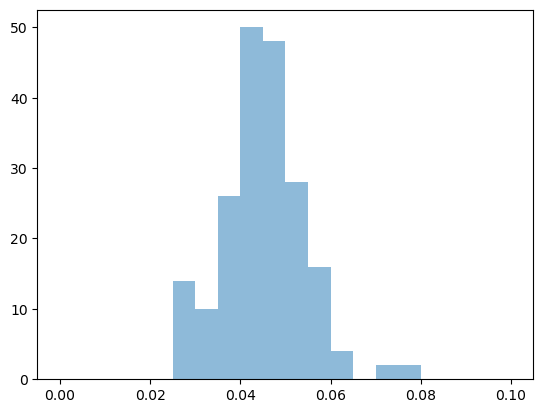

In [1274]:
plt.hist(sim_data, bins=20, density=True, range=(XMIN, XMAX), alpha=.5)


In [1275]:
data = arrs_vh_d
data_mask = ~np.isnan(data)

data_mask.sum()

39884519

In [1276]:
39884519 * .003

119653.557